In [1]:
# Read in the daily data from climate analyzer and calculate monthly averages from daily temps

import json
import random
import matplotlib.pyplot as plt
import datetime
import numpy as np
from IPython.display import Image, display

def get_month_name(day_of_year, year):
    # Create a datetime object for January 1st of the given year
    base_date = datetime.datetime(year, 1, 1)
    
    # Add the number of days to the base date to get the target date
    target_date = base_date + datetime.timedelta(days=day_of_year - 1)
    
    # Format the date as "{Month}"
    month_name = target_date.strftime("%B")
    
    return month_name

# calc future temperature variability rises from single reference points (observed daily temperatures)
def calc_monthly_averages_from_daily_data(cfsr_filepath):
    # Step 1: Load and parse the JSON file
    with open(cfsr_filepath) as file:
        data = json.load(file)

    # Step 2: Filter the data to include only four-digit years
    # Include only years from min_year on
    filtered_data = [entry for entry in data if len(entry['name']) == 4]

    # Step 3: Calculate month averages from daily data
    month_averages = {}
    start_year = 0
    for entry in filtered_data:
        if start_year == 0:
            start_year = int(entry['name'])
        year = int(entry['name'])
        month_total_temp = 0
        num_temps_counted_for_current_month = 0
        month_averages[year] = {}
        for i, temp in enumerate(entry['data']):
            # ignore null values (null place holders at the end of the data for non-leap years)
            day_number_1_indexed = i + 1
            month_name = get_month_name(day_number_1_indexed, year)
            is_last_day_of_month = (get_month_name(day_number_1_indexed + 1, year) != month_name)
            if temp:
                month_total_temp += temp
                num_temps_counted_for_current_month += 1
            if is_last_day_of_month:
                month_averages[year][month_name] = month_total_temp / num_temps_counted_for_current_month
    return month_averages

In [2]:
def getData(gistemp_filepath, cfsr_filepath, extrapolate_year, threshold_year):
    monthly_averages = calc_monthly_averages_from_daily_data(cfsr_filepath)
    
    month_mapping = {
        "04": "January",
        "13": "February",
        "21": "March",
        "29": "April",
        "38": "May",
        "46": "June",
        "54": "July",
        "63": "August",
        "71": "September",
        "79": "October",
        "88": "November",
        "96": "December"
    }

    bulk_year_data = {}
    extrapolate_year_data = {}
    threshold_year_data = {}
    month_max_year = {}  # Variable to store the year for each month's maximum value
    prev_max_value = {}
    
    with open(gistemp_filepath, "r") as file:
        next(file)  # Skip the first row
        next(file)  # Skip the second row
        for line in file:
            data = line.strip().split(",")
            year_month = data[0]
            year = int(year_month.split(".")[0])
            month_decimal = year_month.split(".")[1]
            month_name = month_mapping[month_decimal]
            temp_anomaly = float(data[2])

            # Check if the current value is greater than the previous maximum for the corresponding month
            if month_name not in prev_max_value or temp_anomaly > prev_max_value[month_name]:
                prev_max_value[month_name] = temp_anomaly
                month_max_year[month_name] = year
            
            # Calculate the difference between the two temps (GISTEMP - monthly average for CFSR)
            # First check if we have data for that year, otherwise don't add to data
            if year in monthly_averages:
                # See 1999_Hansen_ha03200f.pdf, section 10. Data Products, about converting to absolute global mean
                offset_for_convert_from_change_to_absolute = 14
                temp_anomaly_difference_from_daily_average = temp_anomaly - monthly_averages[year][month_name] + offset_for_convert_from_change_to_absolute

                # In this notebook calculating the differences between monthly GISTEMP global averages to
                #   monthly averages over daily data from climate_analyzer
                if year == extrapolate_year:
                    if month_name in extrapolate_year_data:
                        extrapolate_year_data[month_name].append(temp_anomaly_difference_from_daily_average)
                    else:
                        extrapolate_year_data[month_name] = [temp_anomaly_difference_from_daily_average]
                elif year == threshold_year:
                    if month_name in threshold_year_data:
                        threshold_year_data[month_name].append(temp_anomaly_difference_from_daily_average)
                    else:
                        threshold_year_data[month_name] = [temp_anomaly_difference_from_daily_average]
                else:
                    if month_name in bulk_year_data:
                        bulk_year_data[month_name].append(temp_anomaly_difference_from_daily_average)
                    else:
                        bulk_year_data[month_name] = [temp_anomaly_difference_from_daily_average]


    # Print the maximum value for each year
    for month_name, year in month_max_year.items():
        max_value = prev_max_value[month_name]
        print(f"Maximum value for {month_name} reached in {year}: {max_value} C")
    return bulk_year_data, extrapolate_year_data, threshold_year_data


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# file path to local copy of json wih temp data
# from https://climatereanalyzer.org/clim/t2_daily/json/cfsr_world_t2_day.json
cfsr_filepath = 'cfsr_world_t2_day.json'

month_averages = calc_monthly_averages_from_daily_data(cfsr_filepath)

def graph_strip_plot(bulk_year_data, extrapolate_year_data, threshold_year_data, rise_threshold):
    fig, ax = plt.subplots(figsize=(8, 12))

    # Create a list of all data points and their corresponding labels
    data = []
    labels = []
    hue = []

    for month_name, temp_anomalies in bulk_year_data.items():
        data.extend(temp_anomalies)
        labels.extend([month_name] * len(temp_anomalies))
        hue.extend(['All Other Years'] * len(temp_anomalies))

    for month_name, temp_anomalies in threshold_year_data.items():
        data.extend(temp_anomalies)
        labels.extend([month_name] * len(temp_anomalies))
        hue.extend(['Threshold Year'] * len(temp_anomalies))

    for month_name, temp_anomalies in extrapolate_year_data.items():
        data.extend(temp_anomalies)
        labels.extend([month_name] * len(temp_anomalies))
        hue.extend(['Extrapolate Year'] * len(temp_anomalies))

    # Set the style of the strip plot
    sns.stripplot(x=labels, y=data, hue=hue, dodge=True, alpha=0.9, palette=['#1f77b4', '#ff7f0e', '#ffdf00'], linewidth=0)

    # Set the y-axis label
    ax.set_ylabel('Temperature Difference between GISTEMP monthly anomalies and monthly averaged CFSR data (C) (+14 C offset)')

    # Move the legend to the right of the chart
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Set the x-axis to be at the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Set more subticks on the y-axis
    plt.yticks(np.arange(-2.5, 2.6, 0.1))

    # Add faint horizontal grey lines for each y tick
    for y_tick in ax.get_yticks():
        ax.axhline(y=y_tick, color='gray', linestyle='dotted', alpha=0.5)

    # Increase spacing between each month
    plt.subplots_adjust(wspace=0.6)
        
    # Add a title to the chart
    plt.title('Difference of Global Monthly Temperature Anomalies' + '\n' + 
              'Land + Ocean Temperature (GISTEMP)' + '\n' +
              'From Daily Average Data (CFSR)'
             )

    
    # Show the plot
    plt.show()


In [4]:
def graph_temps(gistemp_filepath, cfsr_filepath, extrapolate_year, threshold_year, rise_threshold):
    bulk_year_data, extrapolate_year_data, threshold_year_data = getData(gistemp_filepath, cfsr_filepath, extrapolate_year, threshold_year)
    graph_strip_plot(bulk_year_data, extrapolate_year_data, threshold_year_data, rise_threshold)

In [5]:
#### CONFIG FOR MAIN PARAMETERS
# current year of missing months
extrapolate_year = 2023
# file path to CSV for Monthly Mean Global Surface Temperature
# from https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Monthly_Mean_Global_Surface_Temperature/graph.csv
gistemp_filepath = 'global_temp_monthly_mean.csv'
# file path to local copy of json wih temp data
# from https://climatereanalyzer.org/clim/t2_daily/json/cfsr_world_t2_day.json
cfsr_filepath = 'cfsr_world_t2_day.json'
# threshold for new record monthly land+ocean temp anomaly (must exceed this value to be new anomaly record)
rise_threshold = 1.37
# year in which record was broken (year of the rise_threshold)
threshold_year = 2016

Maximum value for January reached in 2016: 1.17 C
Maximum value for February reached in 2016: 1.37 C
Maximum value for March reached in 2016: 1.36 C
Maximum value for April reached in 2020: 1.13 C
Maximum value for May reached in 2020: 1.01 C
Maximum value for June reached in 2023: 1.07 C
Maximum value for July reached in 2019: 0.94 C
Maximum value for August reached in 2016: 1.01 C
Maximum value for September reached in 2020: 0.98 C
Maximum value for October reached in 2015: 1.09 C
Maximum value for November reached in 2020: 1.1 C
Maximum value for December reached in 2015: 1.16 C


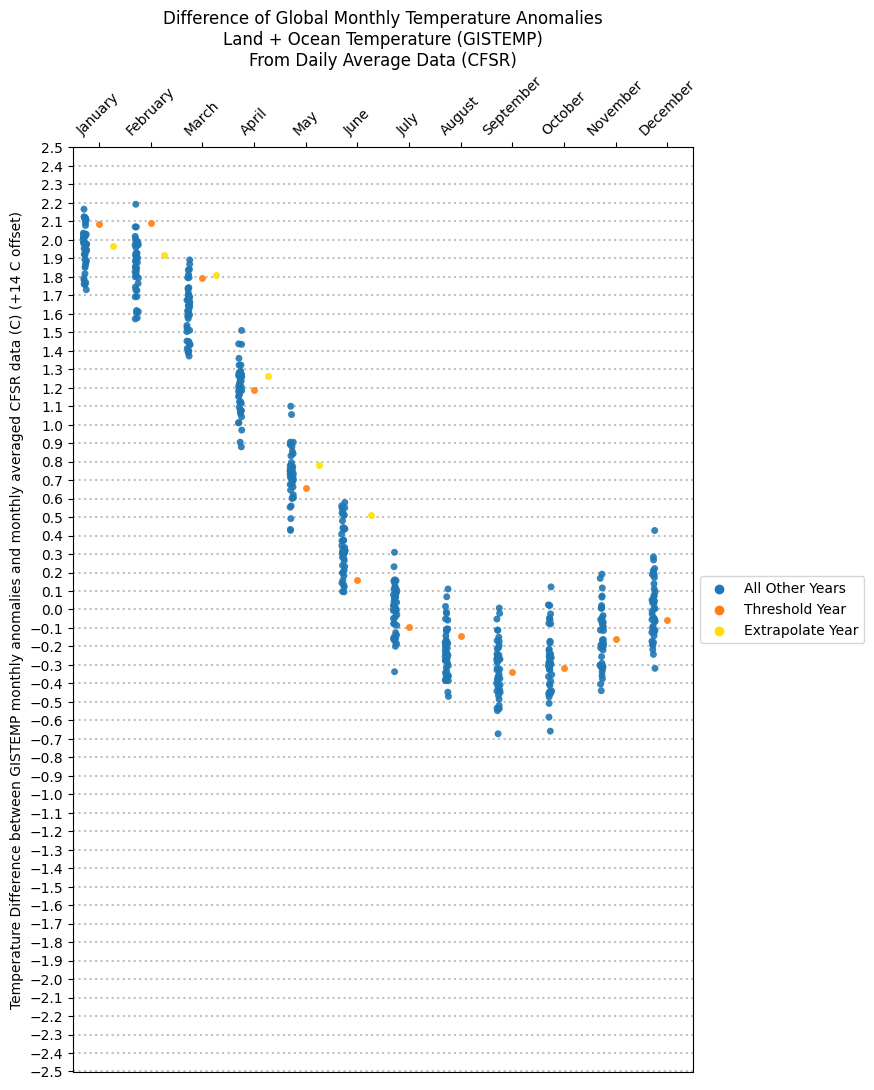

In [6]:
graph_temps(gistemp_filepath, cfsr_filepath, extrapolate_year, threshold_year, rise_threshold)